# xgboost prediction with optimization technique for tennis betting

In this Kernel I will provide optimization model of obtained classification model. Optimization model allow us to bet optimal amount of cash on corresponding matches within the week.

All the data is from http://tennis-data.co.uk/data.php.  
We have all the tennis matches played in the ATP World Tour (Grand Slams, Masers, Master 1000 & ATP500) since January 2000, and until March 2018.

There is much information in this dataset. This notebook will focus only on a quick analysis of the betting market, and propose a betting strategy that generates a non negligible return on investment. 

The full code is available on github : https://github.com/Tomkess/atp_betting.git.

In [278]:
# Library Loading
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data
atp_data = pd.read_csv("Generated Data/atp_data.csv", low_memory = False)
pred_data = pd.read_csv("Generated Data/predict_data.csv", low_memory = False)
pred_data["Date"] = pd.to_datetime(pred_data.Date)

# Specify Betting Period
test_date_i = datetime(2019, 1, 1)

atp_data["Date"] = pd.to_datetime(atp_data.Date)
atp_data_subset = atp_data[["Date", "Tournament", "Winner", "Loser", "PSW", "PSL", "B365W", "B365L"]]
atp_data_subset = atp_data_subset[(atp_data_subset.Date > test_date_i)]

## ----- Select only TOP Tournament ----- ##
atp_data_subset = atp_data_subset[atp_data_subset["Tournament"].isin(["French Open", "Australian Open", 
                                                                      "Wimbledon", "US Open"])]

## ----- Assign Win Loss ----- ##
master_data = atp_data_subset.merge(pred_data,
                                    left_on = ["Winner", "Date"],
                                    right_on = ["Player", "Date"])
master_data = pd.DataFrame(master_data)
master_data.rename(columns = {"1": "w_winner", "0":"l_winner"}, inplace = True)
master_data = master_data.merge(pred_data,
                                left_on = ["Loser", "Date"],
                                right_on = ["Player", "Date"])
master_data = pd.DataFrame(master_data)
master_data.rename(columns = {"1": "w_loser", "0":"l_loser"}, inplace = True)

master_data.drop(["win_loss_x", "win_loss_y", "Player_x", "Player_y"], axis = 1, inplace = True)
master_data["winner_prob"] = master_data["w_winner"]/2 + master_data["l_loser"]/2
master_data["loser_prob"] = master_data["l_winner"]/2 + master_data["w_loser"]/2
master_data.drop(["l_winner", "w_winner", "l_loser", "w_loser"], axis = 1, inplace = True)

# - Is prediction Correct?
master_data['pred_bet'] = ['winner' if x > 0.5 else 'loser' for x in master_data['winner_prob']]
master_data['is_win_bet'] = [1 if x > 0.5 else 0 for x in master_data['winner_prob']]

# - Create Payoff Function
master_data['bet_prob'] = np.where((master_data['pred_bet'] == "winner"), master_data['winner_prob'], master_data["loser_prob"])
master_data['ps_payoff'] = np.where((master_data['pred_bet'] == "winner"), master_data['PSW'], master_data["PSL"])
master_data['b365_payoff'] = np.where((master_data['pred_bet'] == "winner"), master_data['B365W'], master_data["B365L"])
master_data["is_dummy"] = 1

# - Printing Message
print(master_data.head)
print(master_data.is_win_bet.sum()/len(master_data))

<bound method NDFrame.head of            Date       Tournament        Winner              Loser   PSW  \
0    2019-01-14  Australian Open  Anisimova A.       Niculescu M.  1.81   
1    2019-01-14  Australian Open      Babos T.          Jabeur O.  2.46   
2    2019-01-14  Australian Open    Sakkari M.       Ostapenko J.  1.57   
3    2019-01-14  Australian Open  Kontaveit A.  Sorribes Tormo S.  1.16   
4    2019-01-14  Australian Open     Kerber A.          Hercog P.  1.04   
...         ...              ...           ...                ...   ...   
1265 2020-01-30  Australian Open   Muguruza G.           Halep S.  2.53   
1266 2020-01-30  Australian Open   Djokovic N.         Federer R.  1.14   
1267 2020-01-31  Australian Open      Thiem D.          Zverev A.  1.53   
1268 2020-02-01  Australian Open      Kenin S.        Muguruza G.  2.62   
1269 2020-02-02  Australian Open   Djokovic N.           Thiem D.  1.27   

        PSL  B365W B365L  winner_prob  loser_prob pred_bet  is_win_be

# Optimization Model

## Optimization Settings

Optimization runs on each day. There is unique data frame that controls the matches that we bet on, namely **unique_dates**. There are five restrictions imposed on the list of daily matches.

* we bet only on Grandslam Matches (I believe that smaller tournaments are less predictable)

* we bet only on matches with probability of win at least 55%

* we do not bet on days where there is less then 5 matches in total

* in cases with more than 15 matches in a day we take only the first 15 with highest probability of Player to win

* we bet 2000 units (USD for example) in each day that fulfill previous restrictions

## Description of the Optimization Model

The optimization relies on the Portfolio Theory from the field of Finance, namely Sharpe Ratio. During the computation we maximize the Sharpe Ratio with respect to weights (see https://en.wikipedia.org/wiki/Sharpe_ratio).

Sharpe Ratio = Exp Returns/SD Returns

Expected Returns = w * (prob * payoff - 1), where **prob** is probability of win of Player in the match and **payoff** is corresponding bookmakers odd.

SD Returns = weights.T * (payoff * (prob) * (1 - prob)) * weights

## Get unique_dates

In [279]:
unique_dates = master_data.drop_duplicates(["Date", "is_dummy", "Tournament"])
unique_dates = unique_dates[["Date", "is_dummy", "Tournament"]]
unique_dates.reset_index(drop = True, inplace = True)
print(unique_dates.head)

<bound method NDFrame.head of          Date  is_dummy       Tournament
0  2019-01-14         1  Australian Open
1  2019-01-15         1  Australian Open
2  2019-01-16         1  Australian Open
3  2019-01-17         1  Australian Open
4  2019-01-18         1  Australian Open
..        ...       ...              ...
64 2020-01-29         1  Australian Open
65 2020-01-30         1  Australian Open
66 2020-01-31         1  Australian Open
67 2020-02-01         1  Australian Open
68 2020-02-02         1  Australian Open

[69 rows x 3 columns]>


In [283]:
from scipy.optimize import minimize

unique_dates["net_profit"] = 0
unique_dates["n_matches"] = 0
unique_dates["n_good"] = 0

for i in range(len(unique_dates)):
    # i = 1
    date_sel = unique_dates.Date[i]
    tournament_sel = unique_dates.Tournament[i]
    temp_subset = master_data[(master_data.Date == date_sel) & (master_data.Tournament == tournament_sel)]
    temp_subset = temp_subset.sort_values(by = ['bet_prob'], ascending = False)
    temp_subset = temp_subset[temp_subset.bet_prob > 0.55]
    
    # print(len(temp_subset))
    if(len(temp_subset) > 4):
        
        if(len(temp_subset) > 15):
            temp_subset = temp_subset.head(15)
        
            # define sharpe ratio function
            def get_ret_vol_sr(weights):
                """
                Input - weight vector over which the optimization is running
                Output - expected return, voaltility and optima betting stakes
                """
                weights = np.array(weights)
                ret = np.sum((temp_subset.bet_prob * temp_subset.ps_payoff - 1) * weights)
                vol = np.sqrt(np.dot(weights.T, temp_subset.ps_payoff * (temp_subset.bet_prob) * (1 - temp_subset.bet_prob) * weights))
                sr = ret/vol
                return np.array([ret, vol, sr])

            # minimize negative Sharpe Ratio
            def neg_sharpe(weights):
                """
                Input - weight vector
                Output - Sharpe Ratio that will be optimized
                """
                return get_ret_vol_sr(weights)[2] * -1

            # check allocation sums to 1
            def check_sum(weights):
                """
                Input - weights vector
                Output - budget is always summed up to 1!
                """
                return np.sum(weights) - 1

            # create constraint variable
            cons = ({'type':'eq', 'fun':check_sum})

            # create weight boundaries
            bounds = ((0.01, 1),) * len(temp_subset)

            # initial guess
            init_guess = np.repeat(1/len(temp_subset), len(temp_subset), axis = 0)

            # run optimization
            opt_results = minimize(neg_sharpe, init_guess, method = 'SLSQP', bounds = bounds, constraints = cons)

            unique_dates.n_matches[i] = len(temp_subset)
            unique_dates.n_good[i] = np.sum(temp_subset.is_win_bet)
            unique_dates.net_profit[i] = np.sum(2000 * opt_results.x * (temp_subset.ps_payoff) * temp_subset.is_win_bet) - 2000

C:\UserData\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\UserData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\UserData\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Cumulative Net Balanace of Betting

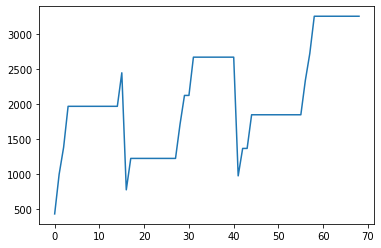

In [284]:
unique_dates.net_profit.cumsum().plot()

## Cumulative Accuracy

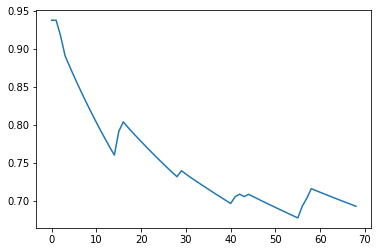

In [285]:
(unique_dates.n_good.cumsum()/(unique_dates.n_matches + 1).cumsum()).plot()

# Conclusion

In the project I focused on applying machine learnign model for predicting the results of tennis matches. On the predictions, we applied optimization technique that allow us to bet on each match such amount that reflect the risk of bets and maximizes the expected returns.

From the results, we might see that matches are predictable to some degree and with more changes in optimization setting and applied method, we might see some nice results.